<a href="https://colab.research.google.com/github/marti1310/TweetClassification/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Groupe 14
- AGÜERA SANCHEZ Martina (22101917)
- BOUBY Lucien (22011624)
- GONG Ni (22025419)
- MACKOW Anaïs (22016204)

# Installations

In [ ]:
!pip install optuna
!pip install emoji
!pip install imblearn
!pip install langdetect
!pip install xgboost
!pip install tensorflow
!pip install transformers
!pip install torch
!pip install gensim
!pip install scikit-multilearn

In [ ]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import logging
import nltk
import emoji
import re
import string
import plotly.express as px
import statistics
import xgboost
import seaborn as sns
import spacy


from sklearn.decomposition import TruncatedSVD
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from google.colab import drive
from joblib import load
from IPython.display import display
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support as score, make_scorer, precision_score, f1_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import Pipeline
from langdetect import detect
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import multilabel_confusion_matrix
from skmultilearn.problem_transform import LabelPowerset
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multioutput import ClassifierChain


drive.mount('/content/gdrive')
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger("optuna").setLevel(logging.WARNING)
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
local = '/content/gdrive/MyDrive/Colab Notebooks/ML1/Projet'
os.chdir(local)
os.getcwd()

'/content/gdrive/MyDrive/Colab Notebooks/ML1/Projet'

#PREPROCESSING
1. Expand abbreviations
2. Replace URL, year, number
3. Lower case
4. Remove mentions, hashtags, emojis
5. Lemmatisation

In [ ]:
TWITTER_ABBREVIATIONS = {
    "u": "you",
    "ur": "your",
    "r": "are",
    "y": "why",
    "pls": "please",
    "plz": "please",
    "thx": "thanks",
    "k": "okay",
    "lol": "laughing out loud",
    "idk": "i do not know",
    "imo": "in my opinion",
    "lmao": "laughing my ass off",
    "brb": "be right back",
    "btw": "by the way",
    "omg": "oh my god",
    "ttyl": "talk to you later",
    "smh": "shaking my head",
    "fyi": "for your information",
    "ppl": "people",
    "some1": "someone",
    "b4": "before",
    "gr8": "great",
    "bff": "best friends forever",
    "wtf": "what the fuck",
    "tbh": "to be honest",
    "bc": "because",
    "nvm": "never mind",
    "u2": "you too",
    "cuz": "because",
    "wanna": "want to",
    "gonna": "going to",
    "ab": "about", "abt": "about", "b/c": "because", "b": "be", "b4": "before",
    "bfn": "bye for now", "bgd": "background", "br": "best regards", "btw": "by the way",
    "chk": "check", "cld": "could", "clk": "click", "cre8": "create", "da": "the",
    "deets": "details", "dm": "direct message", "em": "email", "eml": "email",
    "ema": "email address", "f2f": "face to face", "fab": "fabulous", "ff": "followfriday",
    "ftl": "for the loss", "ftw": "for the win", "hand": "have a nice day", "ht": "hat tip",
    "ic": "i see", "icymi": "in case you missed it", "idk": "i don't know", "imo": "in my opinion",
    "kk": "okay", "mtf": "more to follow", "nts": "note to self", "oh": "overheard",
    "prt": "please retweet", "rt": "retweet", "smh": "shaking my head", "sns": "social networking site",
    "sp": "sponsored", "tbh": "to be honest", "tbt": "throwback thursday", "tftf": "thanks for the follow",
    "tmb": "tweet me back", "u": "you", "woz": "was", "wtv": "whatever", "ykyat": "you know you're addicted to",
    "yolo": "you only live once", "yoyo": "you're on your own"
}




In [ ]:
import nltk
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def expand_abbreviations(text, abbreviations_dict=TWITTER_ABBREVIATIONS):
    words = text.split()
    expanded_words = []
    for word in words:
        # Nettoyage ponctuel pour uniformiser
        word_clean = re.sub(r'\W+', '', word.lower())  # supprime la ponctuation pour matcher
        if word_clean in abbreviations_dict:
            expanded = abbreviations_dict[word_clean]
            expanded_words.append(expanded)
        else:
            expanded_words.append(word)
    return ' '.join(expanded_words)


def remove_stopwords(text, lang):
    stop_words = set(stopwords.words(lang))  # ou 'english'

    words = word_tokenize(text)
    return ' '.join([w for w in words if w.lower() not in stop_words])

def remove_punctuation(text):
    # remplace les guillemets et apostrophes typographiques par leurs équivalents ASCII
    text = text.replace("“", '"').replace("”", '"').replace("’", "'")

    # supprime toute ponctuation ASCII standard
    return text.translate(str.maketrans('', '', string.punctuation))

def replace(text, rep):
  if (rep == 0):
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\b(19|20)\d{2}\b", "year", text)
    text = re.sub(r'\b\d+(\.\d+)?\b', '', text)
  else:
    text = re.sub(r"http\S+|www\S+", "url", text)
    text = re.sub(r"\b(19|20)\d{2}\b", "year", text)
    text = re.sub(r'\b\d+(\.\d+)?\b', 'num', text)
  return text

def preprocess(text):
  text = text.lower()
  text = re.sub(r"@\w+", '', text)  # mentions
  text = re.sub(r"#", "", text)
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = emoji.demojize(text)

  return text

def lem_words(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

def full_clean(text):
    text = expand_abbreviations(text)
    text = replace(text, 0)
    text = preprocess(text)
    text = remove_punctuation(text)
    text = lem_words(text)
    return text



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#Définitions de fonctions

In [ ]:
def tfidf_vectorizer(df_text):
  tfidf = TfidfVectorizer(max_features=100, stop_words='english',ngram_range=(1, 3))
  df_listed = df_text.tolist()
  vect = tfidf.fit_transform(df_listed)

  return vect


In [ ]:
def word2vec_vectorizer(df_text):
    cleaned_text = df_text.apply(full_clean)
    tokenized_text = cleaned_text.apply(lambda x: word_tokenize(x))
    model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

    vectors = tokenized_text.apply(lambda x: np.mean([model.wv[word] for word in x if word in model.wv], axis=0) if len(x) > 0 else np.zeros(100))


    vectors = vectors.apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(100))

    return np.array(vectors.tolist())


In [ ]:
def visualisation_3D(text, labels):
  svd = TruncatedSVD(n_components=3, random_state=42)
  X = svd.fit_transform(text)

  df_3d = pd.DataFrame(X, columns=["x", "y", "z"])
  df_3d["label"] = labels.values

  fig = px.scatter_3d(df_3d, x="x", y="y", z="z",
                    color="label", title="TF-IDF + SVD (3D)")
  fig.show()


In [ ]:
def plot_boxplot(f1_scores, task_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=pd.DataFrame(f1_scores))
    plt.title(f'Distribution des scores F1 pour {task_name}')
    plt.ylabel('Score F1')
    plt.xlabel('Classificateur')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{task_name.replace(" ", "_")}_boxplot.png')
    plt.show()

In [ ]:
def optimize_hyperparameters(classifier_name, X_train, y_train, n_trials=20):
    def objective(trial):
        if classifier_name == 'RandomForestClassifier':
            n_estimators = trial.suggest_int('n_estimators', 10, 200)
            max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
            clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                         class_weight='balanced', random_state=42)

        elif classifier_name == 'SVC':
            C = trial.suggest_float('C', 1e-3, 1e2, log=True)
            kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
            gamma = trial.suggest_float('gamma', 1e-4, 1e-1, log=True)
            clf = SVC(C=C, kernel=kernel, gamma=gamma, class_weight='balanced', probability=True)

        elif classifier_name == 'MultinomialNB':
            alpha = trial.suggest_float('alpha', 1e-3, 1.0, log=True)
            clf = MultinomialNB(alpha=alpha)

        elif classifier_name == 'KNeighborsClassifier':
            n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
            weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
            clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)

        elif classifier_name == 'DecisionTreeClassifier':
            max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
            clf = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion,
                                         class_weight='balanced', random_state=42)

        elif classifier_name == 'LogisticRegression':
            C = trial.suggest_float('C', 1e-3, 1e2, log=True)
            solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
            clf = LogisticRegression(C=C, solver=solver, class_weight='balanced',
                                     max_iter=1000, random_state=42)
        elif classifier_name == 'xgboost':
            max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
            learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
            n_estimators = trial.suggest_int('n_estimators', 10, 1000, log=True)
            clf = xgboost.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)

        # Cross-validation interne à Optuna
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scorer = make_scorer(f1_score, zero_division=0)
        score = cross_val_score(clf, X_train, y_train, cv=cv, scoring=scorer).mean()
        return score



    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

In [ ]:
def test_optuna_binary(X, y):
  best_f1 = 0.0
  names = ""
  model = None
  seed = 42
  models = []
  all_f1_scores = {}


  for clf_name in ['RandomForestClassifier', 'SVC', 'MultinomialNB', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'LogisticRegression', 'xgboost']:
      print(f"\nOptimisation pour : {clf_name}")
      best_params = optimize_hyperparameters(clf_name, X, y, n_trials=20)
      print("Meilleurs paramètres :", best_params)

      if clf_name == "RandomForestClassifier":
          model = RandomForestClassifier(**best_params, class_weight='balanced', random_state=seed)
      elif clf_name == "SVC":
          model = SVC(**best_params, class_weight='balanced', probability=True)
      elif clf_name == "MultinomialNB":
          model = MultinomialNB(**best_params)
      elif clf_name == "KNeighborsClassifier":
          model = KNeighborsClassifier(**best_params)
      elif clf_name == "DecisionTreeClassifier":
          model = DecisionTreeClassifier(**best_params, class_weight='balanced', random_state=seed)
      elif clf_name == "LogisticRegression":
          model = LogisticRegression(**best_params, class_weight='balanced', max_iter=1000, random_state=seed)
      elif clf_name == "xgboost":
          model = xgboost.XGBClassifier(**best_params)


      kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

      f1_scores = []
      accuracy_scores = []
      precision_scores = []
      recall_scores = []


      for train_idx, test_idx in kfold.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred, zero_division=0))
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
        recall_scores.append(recall_score(y_test, y_pred, zero_division=0))


      print(confusion_matrix(y_test, y_pred)) #On peut ne print que la dernière c'est juste pour une idée générale
      f1_mean = statistics.mean(f1_scores)
      if f1_mean > best_f1:
        best_f1 = f1_mean
        names = clf_name
        model = model

      all_f1_scores[clf_name] = f1_scores
      print(f"F1 : {statistics.mean(f1_scores)} \nAccuracy :{statistics.mean(accuracy_scores)} \n Precision : {statistics.mean(precision_scores)} \n Recall: {statistics.mean(recall_scores)}\n")

  plot_boxplot(all_f1_scores,"deuxieme_classification_sur_données_augmentées")
  return model

In [ ]:
def optimize_hyperparameters_multilabel(classifier_name, X_train, y_train, n_trials=20):
    def objective(trial):
        if classifier_name == 'RandomForestClassifier':
            n_estimators = trial.suggest_int('n_estimators', 10, 200)
            max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
            clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                         class_weight='balanced', random_state=42)

        elif classifier_name == 'SVC':
            C = trial.suggest_float('C', 1e-3, 1e2, log=True)
            kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
            gamma = trial.suggest_float('gamma', 1e-4, 1e-1, log=True)
            clf = SVC(C=C, kernel=kernel, gamma=gamma, class_weight='balanced', probability=True)

        elif classifier_name == 'MultinomialNB':
            alpha = trial.suggest_float('alpha', 1e-3, 1.0, log=True)
            clf = MultinomialNB(alpha=alpha)

        elif classifier_name == 'KNeighborsClassifier':
            n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
            weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
            clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)

        elif classifier_name == 'DecisionTreeClassifier':
            max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
            clf = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion,
                                         class_weight='balanced', random_state=42)

        elif classifier_name == 'LogisticRegression':
            C = trial.suggest_float('C', 1e-3, 1e2, log=True)
            solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
            clf = LogisticRegression(C=C, solver=solver, class_weight='balanced',
                                     max_iter=1000, random_state=42)
        elif classifier_name == 'xgboost':
            max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
            learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
            n_estimators = trial.suggest_int('n_estimators', 10, 1000, log=True)
            clf = xgboost.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)

        # Cross-validation interne à Optuna
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scorer = make_scorer(f1_score, average='micro', zero_division=0)
        score = cross_val_score(MultiOutputClassifier(clf), X_train, y_train, cv=cv, scoring=scorer).mean()
        return score



    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

In [ ]:
def test_optuna_multilabel(X0, y0, X_val,y_val):
  best_f1 = 0.0
  names = ""
  estimator = None
  seed = 7

  #X_train, X_test, y_train, y_test
  X,X_val2,y,y_val2 = train_test_split(X0,y0,train_size=0.8,test_size=0.2,random_state=seed)
  for clf_name in ['RandomForestClassifier', 'SVC', 'MultinomialNB', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'LogisticRegression', 'xgboost']:
      print(f"\nOptimisation pour : {clf_name}")
      best_params = optimize_hyperparameters_multilabel(clf_name, X, y, n_trials=20)
      print("Meilleurs paramètres :", best_params)

      if clf_name == "RandomForestClassifier":
          model = RandomForestClassifier(**best_params, class_weight='balanced', random_state=seed)
      elif clf_name == "SVC":
          model = SVC(**best_params, class_weight='balanced', probability=True)
      elif clf_name == "MultinomialNB":
          model = MultinomialNB(**best_params)
      elif clf_name == "KNeighborsClassifier":
          model = KNeighborsClassifier(**best_params)
      elif clf_name == "DecisionTreeClassifier":
          model = DecisionTreeClassifier(**best_params, class_weight='balanced', random_state=seed)
      elif clf_name == "LogisticRegression":
          model = LogisticRegression(**best_params, class_weight='balanced', max_iter=1000, random_state=seed)
      elif clf_name == "xgboost":
          model = xgboost.XGBClassifier(**best_params)
      kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

      f1_scores = []
      accuracy_scores = []
      precision_scores = []
      recall_scores = []


      for train_idx, test_idx in kfold.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        classifier = MultiOutputClassifier(model)

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred, average='micro', zero_division=0))
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='micro', zero_division=0))
        recall_scores.append(recall_score(y_test, y_pred, average='micro', zero_division=0))

      print(multilabel_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))  #On peut ne print que la dernière c'est juste pour une idée générale
      f1_mean = statistics.mean(f1_scores)
      if f1_mean > best_f1:
        best_f1 = f1_mean
        names = clf_name
        estimator = classifier

      print(f"F1 : {statistics.mean(f1_scores)} \nAccuracy :{statistics.mean(accuracy_scores)} \n Precision : {statistics.mean(precision_scores)} \n Recall: {statistics.mean(recall_scores)}\n")

      y_val_pred = classifier.predict(X_val)
      f1_val = f1_score(y_val, y_val_pred, average='micro', zero_division=0)
      print(f"F1 validation sur jeu de base : {f1_val}")

      y_val2_pred = classifier.predict(X_val2)
      f1_val2 = f1_score(y_val2, y_val2_pred, average='micro', zero_division=0)
      print(f"F1 validation sur jeu d'apprentissage : {f1_val2}")
  return estimator

In [ ]:
def optimize_hyperparameters_OneVsOne(classifier_name, X_train, y_train, n_trials=20):
    def objective(trial):
        if classifier_name == 'RandomForestClassifier':
            n_estimators = trial.suggest_int('n_estimators', 10, 200)
            max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
            clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                         class_weight='balanced', random_state=42)

        elif classifier_name == 'SVC':
            C = trial.suggest_float('C', 1e-3, 1e2, log=True)
            kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
            gamma = trial.suggest_float('gamma', 1e-4, 1e-1, log=True)
            clf = SVC(C=C, kernel=kernel, gamma=gamma, class_weight='balanced', probability=True)

        elif classifier_name == 'MultinomialNB':
            alpha = trial.suggest_float('alpha', 1e-3, 1.0, log=True)
            clf = MultinomialNB(alpha=alpha)

        elif classifier_name == 'KNeighborsClassifier':
            n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
            weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
            clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)

        elif classifier_name == 'DecisionTreeClassifier':
            max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
            clf = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion,
                                         class_weight='balanced', random_state=42)

        elif classifier_name == 'LogisticRegression':
            C = trial.suggest_float('C', 1e-3, 1e2, log=True)
            solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
            clf = LogisticRegression(C=C, solver=solver, class_weight='balanced',
                                     max_iter=1000, random_state=42)
        elif classifier_name == 'xgboost':
            max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
            learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
            n_estimators = trial.suggest_int('n_estimators', 10, 1000, log=True)
            clf = xgboost.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)

        # Cross-validation interne à Optuna
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scorer = make_scorer(f1_score, average='micro', zero_division=0)
        score = cross_val_score(OneVsOneClassifier(clf), X_train, y_train, cv=cv, scoring=scorer).mean()
        return score



    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

In [ ]:
def test_optuna_powerset(X0, y0, X_val,y_val):
  powerset = LabelPowerset()
  y1 = powerset.transform(y0)
  y_val_transformed = powerset.transform(y_val)
  best_f1 = 0.0
  names = ""
  estimator = None
  seed = 7

  X,X_val2,y,y_val2 = train_test_split(X0,y1,train_size=0.8,test_size=0.2,random_state=seed)
  print(np.array(y).shape)
  for clf_name in ['RandomForestClassifier', 'SVC', 'MultinomialNB', 'KNeighborsClassifier', 'DecisionTreeClassifier', 'LogisticRegression', 'xgboost']:
      print(f"\n Optimisation pour : {clf_name}")
      best_params = optimize_hyperparameters_OneVsOne(clf_name, X, y, n_trials=20)
      print(" Meilleurs paramètres :", best_params)

      if clf_name == "RandomForestClassifier":
          model = RandomForestClassifier(**best_params, class_weight='balanced', random_state=seed)
      elif clf_name == "SVC":
          model = SVC(**best_params, class_weight='balanced', probability=True)
      elif clf_name == "MultinomialNB":
          model = MultinomialNB(**best_params)
      elif clf_name == "KNeighborsClassifier":
          model = KNeighborsClassifier(**best_params)
      elif clf_name == "DecisionTreeClassifier":
          model = DecisionTreeClassifier(**best_params, class_weight='balanced', random_state=seed)
      elif clf_name == "LogisticRegression":
          model = LogisticRegression(**best_params, class_weight='balanced', max_iter=1000, random_state=seed)
      elif clf_name == "xgboost":
          model = xgboost.XGBClassifier(**best_params)
      kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

      f1_scores = []
      accuracy_scores = []
      precision_scores = []
      recall_scores = []


      for train_idx, test_idx in kfold.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        classifier = OneVsOneClassifier(model)

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred, average='micro', zero_division=0))
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='micro', zero_division=0))
        recall_scores.append(recall_score(y_test, y_pred, average='micro', zero_division=0))

      print(confusion_matrix(y_test,y_pred))  #On peut ne print que la dernière c'est juste pour une idée générale
      f1_mean = statistics.mean(f1_scores)
      if f1_mean > best_f1:
        best_f1 = f1_mean
        names = clf_name
        estimator = classifier

      print(f"F1 : {statistics.mean(f1_scores)} \nAccuracy :{statistics.mean(accuracy_scores)} \n Precision : {statistics.mean(precision_scores)} \n Recall: {statistics.mean(recall_scores)}\n")

      y_val_pred = classifier.predict(X_val)
      f1_val = f1_score(y_val_transformed, y_val_pred, average='micro', zero_division=0)
      print(f"F1 validation sur jeu de base : {f1_val}")

      y_val2_pred = classifier.predict(X_val2)
      f1_val2 = f1_score(y_val2, y_val2_pred, average='micro', zero_division=0)
      print(f"F1 validation sur jeu d'apprentissage : {f1_val2}")
  return estimator

In [ ]:
def optimize_hyperparameters_multi_power(classifier_name, X_train, y_train, n_trials=20):
    def objective(trial):
        if classifier_name == 'RandomForestClassifier':
            n_estimators = trial.suggest_int('n_estimators', 10, 200)
            max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
            clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                         class_weight='balanced', random_state=42)

        elif classifier_name == 'LogisticRegression':
            C = trial.suggest_float('C', 1e-3, 1e2, log=True)
            solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
            clf = LogisticRegression(C=C, solver=solver, class_weight='balanced',
                                     max_iter=1000, random_state=42)

        elif classifier_name == 'xgboost':
            max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
            learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
            n_estimators = trial.suggest_int('n_estimators', 10, 1000, log=True)
            clf = xgboost.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate,
                                        n_estimators=n_estimators, eval_metric='mlogloss')

        # Cross-validation avec scoring multi-classe (car Label Powerset)
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scorer = make_scorer(f1_score, average='micro', zero_division=0)
        score = cross_val_score(clf, X_train, y_train, cv=cv, scoring=scorer).mean()
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    return study.best_params


In [ ]:
def test_multi_powerset(X, y, X_val=None, y_val_transformed=None, X_val2=None, y_val2=None):
    best_f1 = 0.0
    best_model = None
    seed = 42

    for clf_name in ['RandomForestClassifier', 'LogisticRegression', 'xgboost']:
        print(f"\n Optimisation pour : {clf_name}")
        best_params = optimize_hyperparameters_multi_power(clf_name, X, y, n_trials=20)
        print("Meilleurs paramètres :", best_params)

        if clf_name == "RandomForestClassifier":
            model = RandomForestClassifier(**best_params, class_weight='balanced', random_state=seed)
        elif clf_name == "LogisticRegression":
            model = LogisticRegression(**best_params, class_weight='balanced', max_iter=1000, random_state=seed)
        elif clf_name == "xgboost":
            model = xgboost.XGBClassifier(**best_params)

        kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
        f1_scores = []
        accuracy_scores = []
        precision_scores = []
        recall_scores = []

        for train_idx, test_idx in kfold.split(X, y):
            X_train_fold, X_test_fold = X[train_idx], X[test_idx]
            y_train_fold, y_test_fold = y[train_idx], y[test_idx]

            model.fit(X_train_fold, y_train_fold)
            y_pred_fold = model.predict(X_test_fold)

            f1_scores.append(f1_score(y_test_fold, y_pred_fold, average='micro', zero_division=0))
            accuracy_scores.append(accuracy_score(y_test_fold, y_pred_fold))
            precision_scores.append(precision_score(y_test_fold, y_pred_fold, average='micro', zero_division=0))
            recall_scores.append(recall_score(y_test_fold, y_pred_fold, average='micro', zero_division=0))

        f1_mean = statistics.mean(f1_scores)
        print(confusion_matrix(y_test_fold, y_pred_fold))
        print(f"F1 : {f1_mean:.4f} \nAccuracy : {statistics.mean(accuracy_scores):.4f} "
              f"\nPrecision : {statistics.mean(precision_scores):.4f} \nRecall : {statistics.mean(recall_scores):.4f}")

        if f1_mean > best_f1:
            best_f1 = f1_mean
            best_model = model

        if X_val is not None and y_val_transformed is not None:
            y_val_pred = model.predict(X_val)
            f1_val = f1_score(y_val_transformed, y_val_pred, average='micro', zero_division=0)
            print(f"F1 validation sur jeu de base : {f1_val:.4f}")

        if X_val2 is not None and y_val2 is not None:
            y_val2_pred = model.predict(X_val2)
            f1_val2 = f1_score(y_val2, y_val2_pred, average='micro', zero_division=0)
            print(f"F1 validation sur jeu d'apprentissage : {f1_val2:.4f}")

    return best_model

In [ ]:
def external_predict(path, clas, model):
  print("\n External prediction\n")
  print(f"{model}\n")
  df = pd.read_csv(path, sep='\t')
  df['text'] = df['text'].apply(full_clean)
  tfidf_vect = tfidf_vectorizer(df['text'])
  y = df[clas]
  y_pred_proba = model.predict(tfidf_vect)
  y_pred = (y_pred_proba >= 0.5).astype(int)

  print(classification_report(y, y_pred))
  print(confusion_matrix(y, y_pred))
  f1_ext = classification_report(y, y_pred, output_dict=True)['weighted avg']['f1-score']
  print(f1_ext)



In [ ]:
def external_predict2(path, model):
  print("\n External prediction\n")
  print(f"{model}\n")
  df = pd.read_csv(path, sep='\t')
  df['text'] = df['text'].apply(full_clean)
  df = duplicate_row(df)
  df['crc'] = df.apply(map_labels1, axis=1)
  tfidf_vect = tfidf_vectorizer(df['text'])
  y = df['crc']
  y_pred_proba = model.predict(tfidf_vect)
  y_pred = (y_pred_proba >= 0.5).astype(int)

  print(classification_report(y, y_pred))
  print(confusion_matrix(y, y_pred))


In [ ]:
def initialize(path):
  df = pd.read_csv(path, sep='\t')
  df = df.reset_index(drop=True)

  print(df['text'].duplicated().sum())
  df = df.drop('Unnamed: 0', axis=1)

  return df

In [ ]:
def duplicate_row(df):
  rows_to_duplicate = []
  for index, row in df.iterrows():
      if row["scientific_reference"] == 1.0 and row["scientific_context"] == 1.0:
          duplicated_row = row.copy()
          duplicated_row["scientific_reference"] = 0.0
          #print(duplicated_row)
          rows_to_duplicate.append(duplicated_row)

  if rows_to_duplicate:
      duplicated_df = pd.DataFrame(rows_to_duplicate)
      df = pd.concat([df, duplicated_df], ignore_index=True)
  return df

In [ ]:
def map_labels1(row):
    return 1 if (row["scientific_claim"] == 1.0 or row["scientific_reference"] == 1.0) else 0

In [ ]:
def map_labels2(row):
    label = []
    if(row["scientific_claim"] == 1.0):
      label.append(1)
    else:
      label.append(0)
    if(row["scientific_reference"] == 1.0):
      label.append(1)
    else:
      label.append(0)
    if(row["scientific_context"] == 1.0):
      label.append(1)
    else:
      label.append(0)
    return label

In [ ]:
def downsampling(df, clas):
    class_counts = df[clas].value_counts()
    minority_class = class_counts.idxmin()
    minority_count = class_counts.min()

    df_minority = df[df[clas] == minority_class]
    df_majority = df[df[clas] != minority_class]

    df_majority_downsampled = df_majority.sample(n=minority_count, random_state=42)

    balanced_df = pd.concat([df_minority, df_majority_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"{class_counts}\n")
    print(f"{balanced_df[clas].value_counts()}\n")
    balanced_df = balanced_df.dropna(subset=["text"])
    balanced_df = balanced_df.reset_index(drop=True)

    return balanced_df


In [ ]:
def embedded_preprocess(df):
  df_trans = df[(df["scientific_claim"] == 1) |(df["scientific_reference"] == 1) | (df["scientific_context"] == 1)].copy()
  df_trans["label_step1"] = (df_trans["scientific_claim"] == 1).astype(int)
  df_trans = df_trans.reset_index(drop=True)
  df_step2 = df_trans[df_trans["label_step1"] == 0].copy()
  df_step2["label_step2"] = (df_step2["scientific_reference"] == 1).astype(int)
  df_step2 = df_step2.reset_index(drop=True)

  return df_trans, df_step2


In [ ]:
def true_labels(df):
  true_labels = []
  for _, row in df.iterrows():
      if row["scientific_claim"] == 1:
          true_labels.append("claim")
      elif row["scientific_reference"] == 1:
          true_labels.append("reference")
      elif row["scientific_context"] == 1:
          true_labels.append("context")
      else:
          true_labels.append("unknown")  # au cas où
  return true_labels

In [ ]:
def embedded_classification(df1, df2):
  df1['text'].apply(full_clean)
  df2['text'].apply(full_clean)
  vect1 = tfidf_vectorizer(df1["text"])
  vect2 = tfidf_vectorizer(df2["text"])

  bst1 = test_optuna_binary(vect1, df1["label_step1"])
  bst2 = test_optuna_binary(vect2, df2["label_step2"])

  df = pd.read_csv('scitweets_export.tsv', sep='\t')
  df['text'] = df['text'].apply(full_clean)
  vect = tfidf_vectorizer(df['text'])

  pred_step1 = bst1.predict(vect)

  final_preds = []

  for i, p1 in enumerate(pred_step1):
      if p1 == 1:
          final_preds.append("claim")
      else:
          p2 = bst2.predict(vect[i])
          final_preds.append("reference" if p2[0] == 1 else "context")

  tlb = true_labels(df)
  print(classification_report(tlb, final_preds))
  display(confusion_matrix(tlb, final_preds))



In [ ]:
def smote(vect, df, clas):
    if isinstance(vect, np.ndarray):
        X_resampled_1 = vect
    else:
        X_resampled_1 = vect.toarray()

    y_resampled_1 = df[clas].values

    smote = SMOTE(random_state=42)
    X_resampled_1, y_resampled_1 = smote.fit_resample(X_resampled_1, y_resampled_1)

    return X_resampled_1, y_resampled_1


In [ ]:
def powerset(df):
    # Créer les combinaisons binaires de {0, 1} pour chaque ligne
    df['powerset_label_str'] = df.apply(lambda row: f"{int(row['scientific_claim'])}_{int(row['scientific_reference'])}_{int(row['scientific_context'])}", axis=1)
    return df

In [ ]:
def label_encoding(df):
  le = LabelEncoder()
  df['powerset_label_encoded'] = le.fit_transform(df['powerset_label_str'])
  return le, df

In [ ]:
def vocab(df_text):
  vectorizer = CountVectorizer(stop_words='english')

  X = vectorizer.fit_transform(df_text)
  return len(vectorizer.get_feature_names_out()) + 1

In [ ]:
def length_max(text):
  tweet_lengths = [len(tweet.split()) for tweet in text]
  return int(np.percentile(tweet_lengths, 90)  )


In [ ]:
def plot_metrics(f1_scores_train, f1_scores_test, loss_train, loss_test, n_splits):
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_splits + 1), loss_train, label='Training Loss', marker='o')
    plt.plot(range(1, n_splits + 1), loss_test, label='Test Loss', marker='o')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot F1-score
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_splits + 1), f1_scores_train, label='Training F1 Score', marker='o')
    plt.plot(range(1, n_splits + 1), f1_scores_test, label='Test F1 Score', marker='o')
    plt.title('F1 Score per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def lstm_bin(text, labels, epochs=10):
    embedding_dim = 100
    max_length = length_max(text)


    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    y = labels.astype(int).values

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Poids des classes pour gérer l'imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    # Initialisation du modèle
    model = Sequential()
    model.add(Embedding(input_dim=embedding_dim, output_dim=embedding_dim, input_length=max_length))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    f1_scores_train = []
    f1_scores_val = []
    loss_train = []
    loss_val = []

    best_model = None
    best_score = 0

    for epoch in range(epochs):
        print(f"\n=== Epoch {epoch+1}/{epochs} ===")
        model.fit(X_train, y_train, epochs=1, batch_size=32, class_weight=class_weight_dict, verbose=0)

        score_train = model.evaluate(X_train, y_train, verbose=0)
        score_val = model.evaluate(X_val, y_val, verbose=0)

        y_train_pred = (model.predict(X_train) > 0.5).astype(int)
        y_val_pred = (model.predict(X_val) > 0.5).astype(int)

        f1_train = f1_score(y_train, y_train_pred)
        f1_val = f1_score(y_val, y_val_pred)

        f1_scores_train.append(f1_train)
        f1_scores_val.append(f1_val)
        loss_train.append(score_train[0])
        loss_val.append(score_val[0])

        if f1_val > best_score:
            best_score = f1_val
            best_model = model

        print(f"F1 Train: {f1_train:.4f}, F1 Val: {f1_val:.4f}, Val Accuracy: {score_val[1]:.4f}")

    print(f"\n Meilleur F1 Validation : {best_score:.4f}")
    plot_metrics(f1_scores_train, f1_scores_val, loss_train, loss_val, epochs)

    return best_model


In [ ]:
def lstm_multi(text, labels, epochs=11):
    vocab_size = vocab(text) #taille du vocab
    embedding_dim = 100
    max_length = int(length_max(text)) #calculs de la taille max et remplir ceux plus petit
    num_classes = labels.shape[1]

    tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>") #Tokenisation KEras
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    X = pad_sequences(sequences, maxlen=max_length, padding='post')

    y = np.array(labels)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(LSTM(32)) #Essais sur 128, 64 et 43
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    f1_scores_train = []
    f1_scores_val = []
    loss_train = []
    loss_val = []

    best_model = None
    best_score = 0

    for epoch in range(epochs):
        print(f"\n=== Epoch {epoch+1}/{epochs} ===")
        model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)

        # Évaluation
        score_train = model.evaluate(X_train, y_train, verbose=0)
        score_val = model.evaluate(X_val, y_val, verbose=0)

        y_train_pred = (model.predict(X_train) > 0.5).astype(int)
        y_val_pred = (model.predict(X_val) > 0.5).astype(int)

        f1_train = f1_score(y_train, y_train_pred, average='micro', zero_division=0)
        f1_val = f1_score(y_val, y_val_pred, average='micro', zero_division=0)

        f1_scores_train.append(f1_train)
        f1_scores_val.append(f1_val)
        loss_train.append(score_train[0])
        loss_val.append(score_val[0])

        if f1_val > best_score:
            best_score = f1_val
            best_model = model

        print(f"F1 Train: {f1_train:.4f}, F1 Val: {f1_val:.4f}, Val Acc: {score_val[1]:.4f}")

    print(f"\n Meilleur F1 Validation : {best_score:.4f}")
    plot_metrics(f1_scores_train, f1_scores_val, loss_train, loss_val, epochs)

    return best_model


# Analyse des données

### Word Cloud

In [ ]:
def word_cloud(text,min):
    tweet = text.str.cat(sep=' ')
    words = tweet.split()
    word_counts = Counter(words)
    filtered_counts = {word: count for word, count in word_counts.items() if count >= min}

    fig = px.treemap(
        names=list(filtered_counts.keys()),
        parents=[""] * len(filtered_counts),
        values=list(filtered_counts.values()),
        title=f"Word Cloud sous forme de Treemap de l’ensemble des tweets de la SciTweets (affichage des mots ayant un nombre d’occurrences supérieur à {min}"
    )
    fig.update_traces(
        marker=dict(
            colors=list(filtered_counts.values()),
            colorscale=[(0, 'lightblue'), (0.5, 'orange'), (1, 'darkred')],
            colorbar=dict(title="Occurrences")
        )
    )
    fig.show()

In [ ]:
#Affichage de word_cloud
path="scitweets_export.tsv"
df = initialize(path)
print(word_cloud(df['text'],30))
df['text'] = df['text'].apply(full_clean)
print(word_cloud(df['text'],30))

1


None


None


### Corrélations

In [ ]:
path_base="scitweets_export.tsv"
path_final="final.tsv"
df_base = initialize(path_base)
df_final = initialize(path_final)

df_base['text'] = df_base['text'].apply(full_clean)
df_final['text'] = df_final['text'].apply(full_clean)

corr_claim_reference = df_final['scientific_claim'].corr(df_final['scientific_reference'])
corr_claim_related = df_final['scientific_claim'].corr(df_final['science_related'])
corr_reference_related = df_final['scientific_reference'].corr(df_final['science_related'])
corr_claim_reference_base = df_base['scientific_claim'].corr(df_base['scientific_reference'])
corr_claim_related_base = df_base['scientific_claim'].corr(df_base['science_related'])
corr_reference_related_base = df_base['scientific_reference'].corr(df_base['science_related'])

print("Correlation dans le dataset augmenté:\n")
print(corr_claim_reference)
print(corr_claim_related)
print(corr_reference_related)
print("\nCorrelation dans le dataset original:\n")
print(corr_claim_reference_base)
print(corr_claim_related_base)
print(corr_reference_related_base)

1
155
Correlation dans le dataset augmenté:

0.17926109110475655
0.6131115568601044
0.5452734281842554

Correlation dans le dataset original:

0.4199949257936822
0.7821556039724705
0.6648035153192209


### Distribution des classes

In [ ]:
path_base="scitweets_export.tsv"
path_final="final.tsv"
df_base = initialize(path_base)
df_final = initialize(path_final)

print("Distribution pour SciTweets")
print("\n")
print(df_base['science_related'].value_counts())
CLAIMREF = df_base['scientific_reference']+df_base['scientific_claim']
print("Claim/Ref")
print(CLAIMREF.value_counts())
print(df_base['scientific_context'].value_counts())
print(df_base['scientific_reference'].value_counts())
print(df_base['scientific_claim'].value_counts())
print("\n")

print("Distributuion pour Data Augmentée")
print(df_final['science_related'].value_counts())
CLAIMREF = df_final['scientific_reference']+df_final['scientific_claim']
print("Claim/Ref")
print(CLAIMREF.value_counts())
print(df_final['scientific_context'].value_counts())
print(df_final['scientific_reference'].value_counts())
print(df_final['scientific_claim'].value_counts())


1
155
Distribution pour SciTweets


science_related
0    765
1    375
Name: count, dtype: int64
Claim/Ref
0.0    798
1.0    218
2.0    124
Name: count, dtype: int64
scientific_context
0.0    889
1.0    251
Name: count, dtype: int64
scientific_reference
0.0    937
1.0    203
Name: count, dtype: int64
scientific_claim
0.0    877
1.0    263
Name: count, dtype: int64


Distributuion pour Data Augmentée
science_related
0    2393
1    2170
Name: count, dtype: int64
Claim/Ref
0.0    2826
1.0    1345
2.0     392
Name: count, dtype: int64
scientific_context
0.0    3115
1.0    1448
Name: count, dtype: int64
scientific_reference
0.0    3594
1.0     969
Name: count, dtype: int64
scientific_claim
0.0    3403
1.0    1160
Name: count, dtype: int64


### Liste des mots les plus fréquents

In [ ]:
path_base="scitweets_export.tsv"
path_final="final.tsv"
df_base = initialize(path_base)
df_final = initialize(path_final)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_final['text'])
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

word_counts = word_freq.sum(axis=0).sort_values(ascending=False)
print(word_counts.head(10))
print('\n')
X2 = vectorizer.fit_transform(df_base['text'])
word_freq2 = pd.DataFrame(X2.toarray(), columns=vectorizer.get_feature_names_out())
word_counts2 = word_freq2.sum(axis=0).sort_values(ascending=False)

print(word_counts2.head(10))

1
155
https       3130
http         856
support      436
stop         425
new          318
people       244
study        210
science      168
reports      166
research     163
dtype: int64


https       705
http        196
stop        183
support     152
people       74
new          70
reports      62
cause        48
just         42
increase     41
dtype: int64


In [ ]:
def get_word_counts(df, column_name):
    filtered_df = df[df[column_name] == 1]
    X = vectorizer.fit_transform(filtered_df['text'])
    word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    word_counts = word_freq.sum(axis=0).sort_values(ascending=False)
    word_counts = word_counts.head(10)
    return word_counts


# Fonction améliorée pour afficher les résultats sous forme de barres groupées
def plot_comparison_word_counts(claim_counts, reference_counts, context_counts, title):
    # Trouver les 10 mots les plus fréquents (en commun) dans chaque série
    common_words = list(set(claim_counts.index).union(reference_counts.index).union(context_counts.index))
    common_words = common_words[:10]  # Limiter à 10 mots

    # Compléter les séries pour s'assurer que chaque colonne a les mêmes indices
    claim_counts = claim_counts.reindex(common_words, fill_value=0)
    reference_counts = reference_counts.reindex(common_words, fill_value=0)
    context_counts = context_counts.reindex(common_words, fill_value=0)

    # Créer un DataFrame pour comparer les trois catégories
    comparison_df = pd.DataFrame({
        'Mot': common_words,
        'Claim': claim_counts.values,
        'Reference': reference_counts.values,
        'Context': context_counts.values
    })

    # Créer le plot
    comparison_df.set_index('Mot').plot(kind='bar', figsize=(12, 6), color=['#FF6347', '#4682B4', '#32CD32'])

    # Ajouter des labels et un titre
    plt.title(title)
    plt.xlabel('Mots')
    plt.ylabel('Fréquence')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

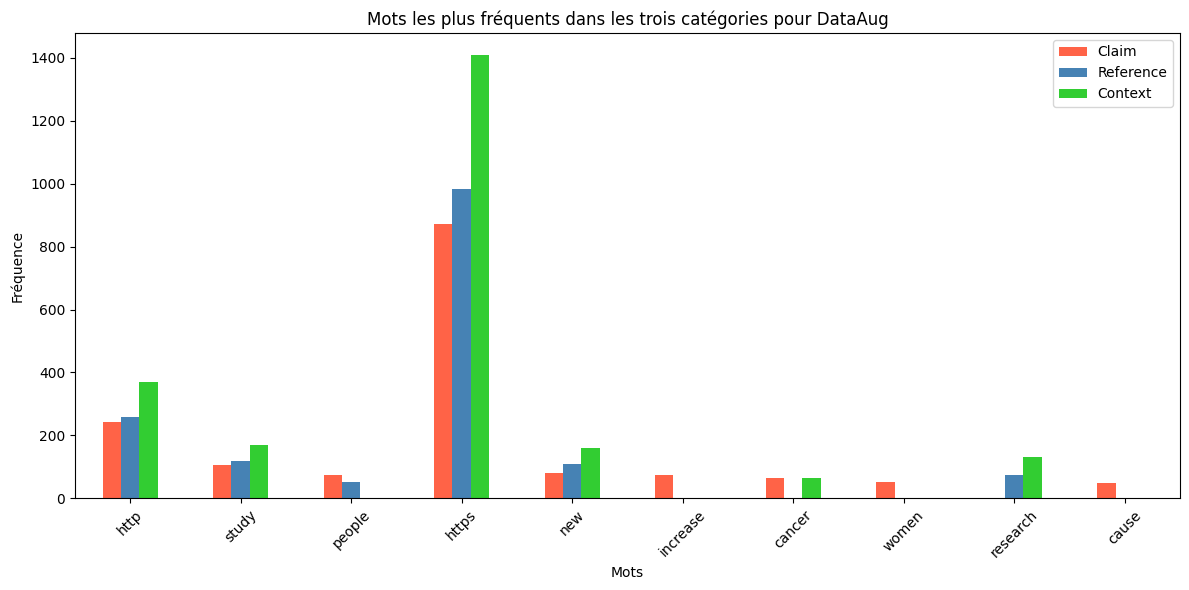

None


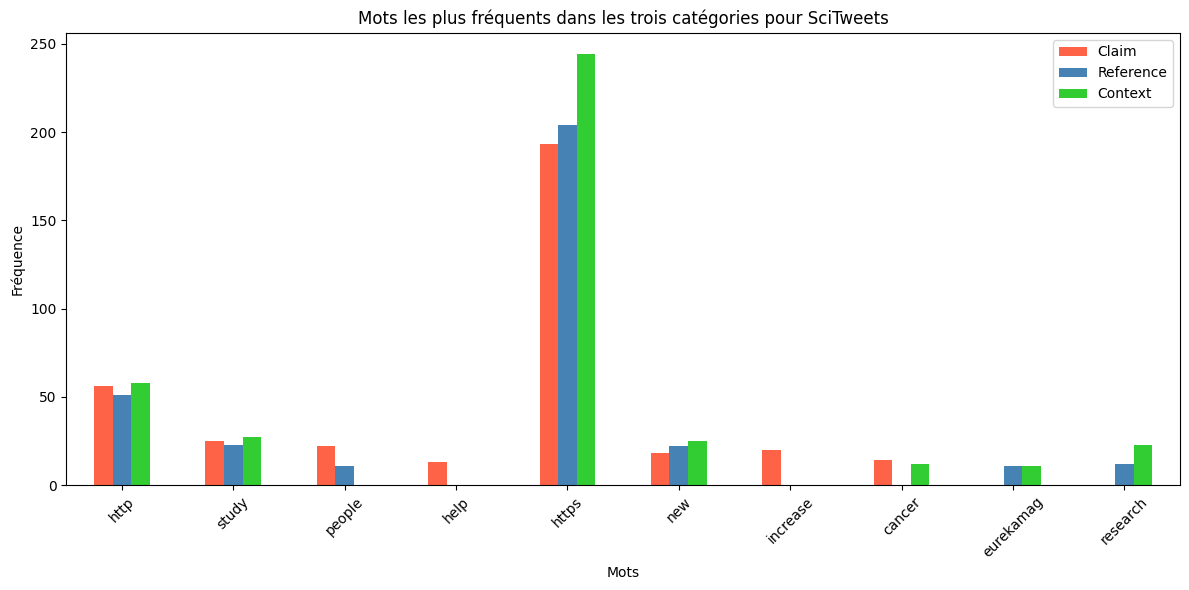

None


In [ ]:
claim_word_counts = get_word_counts(df_final, 'scientific_claim')
reference_word_counts = get_word_counts(df_final, 'scientific_reference')
context_word_counts = get_word_counts(df_final, 'scientific_context')
print(plot_comparison_word_counts(claim_word_counts, reference_word_counts, context_word_counts, 'Mots les plus fréquents dans les trois catégories pour DataAug'))

claim_word_counts2 = get_word_counts(df_base, 'scientific_claim')
reference_word_counts2 = get_word_counts(df_base, 'scientific_reference')
context_word_counts2 = get_word_counts(df_base, 'scientific_context')
print(plot_comparison_word_counts(claim_word_counts2, reference_word_counts2, context_word_counts2, 'Mots les plus fréquents dans les trois catégories pour SciTweets'))

### Distribution des types de mots

In [ ]:
path_base="scitweets_export.tsv"
path_final="final.tsv"
df_base = initialize(path_base)
df_final = initialize(path_final)

# Charger le modèle français de spaCy
nlp = spacy.load('en_core_web_sm')

# Fonction pour obtenir la distribution des types de mots
def pos_distribution(text):
    doc = nlp(text)
    pos_tags = [token.pos_ for token in doc]
    return pos_tags

# Appliquer la fonction sur la colonne 'text'
df_final['pos_tags'] = df_final['text'].apply(pos_distribution)

# Calculer la distribution des types de mots
all_pos_tags = [tag for sublist in df_final['pos_tags'] for tag in sublist]
pos_dist = pd.Series(all_pos_tags).value_counts()

print("Distribution des types de mots :")
print(pos_dist)


1
155
Distribution des types de mots :
NOUN     24267
PROPN    13349
PUNCT    13300
VERB     11366
ADP       9350
ADJ       7044
DET       5916
AUX       4240
PRON      4102
SYM       2801
ADV       2774
PART      2388
CCONJ     2351
NUM       1976
SCONJ     1274
X          764
INTJ       272
SPACE       28
Name: count, dtype: int64


### Analyse n-gramme

In [ ]:
path_base="scitweets_export.tsv"
path_final="final.tsv"
df_base = initialize(path_base)
df_final = initialize(path_final)

vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df_final['text'])

bigram_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

bigram_counts = bigram_freq.sum(axis=0).sort_values(ascending=False)

print("Bi-grammes de SciTweets")
print(bigram_counts.head(10))


1
155
Bi-grammes de SciTweets
new study           26
reports https       26
climate change      24
covid 19            24
https 5piti5xyzr    22
new york            18
science https       18
social media        16
support https       16
50 000              15
dtype: int64


In [ ]:
vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')
X = vectorizer.fit_transform(df_final['text'])

bigram_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

bigram_counts = bigram_freq.sum(axis=0).sort_values(ascending=False)

print("Tri-grammes de SciTweets")
print(bigram_counts.head(10))


Tri-grammes de SciTweets
drug multiple med               11
multiple med uses               11
new drug multiple               11
12 30 pm                         8
31st dec 2020                    8
guide https zfldc2ighl           7
new york city                    7
seven day average                7
community acquired pneumonia     7
leading cause death              6
dtype: int64


In [ ]:
def get_ngram_frequencies(df, column_name, ngram_range=(2, 2)):
    filtered_df = df[df[column_name] == 1]
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(filtered_df['text'])

    ngram_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    ngram_counts = ngram_freq.sum(axis=0).sort_values(ascending=False)

    return ngram_counts

claim_bigrams = get_ngram_frequencies(df_final, 'scientific_claim', ngram_range=(2, 2))
reference_bigrams = get_ngram_frequencies(df_final, 'scientific_reference', ngram_range=(2, 2))
context_bigrams = get_ngram_frequencies(df_final, 'scientific_context', ngram_range=(2, 2))

claim_trigrams = get_ngram_frequencies(df_final, 'scientific_claim', ngram_range=(3, 3))
reference_trigrams = get_ngram_frequencies(df_final, 'scientific_reference', ngram_range=(3, 3))
context_trigrams = get_ngram_frequencies(df_final, 'scientific_context', ngram_range=(3, 3))

print("Top 10 bigrams pour 'scientific_claim':")
print(claim_bigrams.head(10))
print("\nTop 10 bigrams pour 'scientific_reference':")
print(reference_bigrams.head(10))
print("\nTop 10 bigrams pour 'scientific_context':")
print(context_bigrams.head(10))

print("\nTop 10 trigrams pour 'scientific_claim':")
print(claim_trigrams.head(10))
print("\nTop 10 trigrams pour 'scientific_reference':")
print(reference_trigrams.head(10))
print("\nTop 10 trigrams pour 'scientific_context':")
print(context_trigrams.head(10))

Top 10 bigrams pour 'scientific_claim':
new study           26
covid 19            18
climate change      15
heart disease       11
weight loss         11
mental health       10
men http            10
https 5piti5xyzr    10
diabetes https       9
guilt guilt          9
dtype: int64

Top 10 bigrams pour 'scientific_reference':
climate change      19
new study           17
https 5piti5xyzr    14
https risn9v59eb    12
https v7ymac4ifh    12
http n7t5nebadv      9
eurekamag https      9
https m69nonckyd     8
drug multiple        8
https wzajo7udkr     8
dtype: int64

Top 10 bigrams pour 'scientific_context':
climate change      23
new study           19
https 5piti5xyzr    18
eurekamag https     12
https risn9v59eb    12
https v7ymac4ifh    12
https oqnlfru51i    11
science https       11
http n7t5nebadv     10
http qv1c1gjqin     10
dtype: int64

Top 10 trigrams pour 'scientific_claim':
watch video https              6
increase women color           6
leads guilt guilt              6
le

### Diversité lexicale

In [ ]:
path_base="scitweets_export.tsv"
path_final="final.tsv"
df_base = initialize(path_base)
df_final = initialize(path_final)

def lexical_diversity(text):
    words = text.split()
    unique_words = set(words)
    return len(unique_words) / len(words)


def lexical_diversity_by_class(df, column_name):
    filtered_df = df[df[column_name] == 1]
    filtered_df['lexical_diversity'] = filtered_df['text'].apply(lexical_diversity)
    return filtered_df['lexical_diversity'].mean()

claim_density = lexical_diversity_by_class(df_final, 'scientific_claim')
reference_density = lexical_diversity_by_class(df_final, 'scientific_reference')
context_density = lexical_diversity_by_class(df_final, 'scientific_context')


print(f"Densité lexicale pour 'scientific_claim' : {claim_density}")
print(f"Densité lexicale pour 'scientific_reference' : {reference_density}")
print(f"Densité lexicale pour 'scientific_context' : {context_density}")




1
155
Densité lexicale pour 'scientific_claim' : 0.9576344976545011
Densité lexicale pour 'scientific_reference' : 0.9656639402807864
Densité lexicale pour 'scientific_context' : 0.9653010053840486


<ipython-input-104-762ea963ba5f>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-104-762ea963ba5f>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-104-762ea963ba5f>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Classifications

## {SCI} VS {NON-SCI}





In [ ]:
path = 'final.tsv'

df_1 = initialize(path)
df_1['text'] = df_1['text'].apply(full_clean)
vect_1 = word2vec_vectorizer(df_1['text'])
bst = test_optuna_binary(vect_1, df_1['science_related'])
external_predict('scitweets_export.tsv', 'science_related', bst)


155

Optimisation pour : RandomForestClassifier
Meilleurs paramètres : {'n_estimators': 79, 'max_depth': 32}
[[428  50]
 [143 291]]
F1 : 0.7941605925952845 
Accuracy :0.7992544340039585 
 Precision : 0.7812263553095575 
 Recall: 0.8267281105990784


Optimisation pour : SVC
Meilleurs paramètres : {'C': 13.24840465348271, 'kernel': 'rbf', 'gamma': 0.0986535561841281}
[[340 138]
 [ 52 382]]
F1 : 0.7917435094306735 
Accuracy :0.7808473126957591 
 Precision : 0.7225865691167671 
 Recall: 0.876036866359447


Optimisation pour : MultinomialNB
Meilleurs paramètres : {'alpha': 0.7597746973418781}
[[409  69]
 [156 278]]
F1 : 0.7119996102705372 
Accuracy :0.7512586230087815 
 Precision : 0.7922928740695061 
 Recall: 0.6465437788018433


Optimisation pour : KNeighborsClassifier
Meilleurs paramètres : {'n_neighbors': 48, 'weights': 'distance'}
[[427  51]
 [133 301]]
F1 : 0.7819495051178609 
Accuracy :0.8023226878807095 
 Precision : 0.8271363825947939 
 Recall: 0.7506912442396313


Optimisation pou

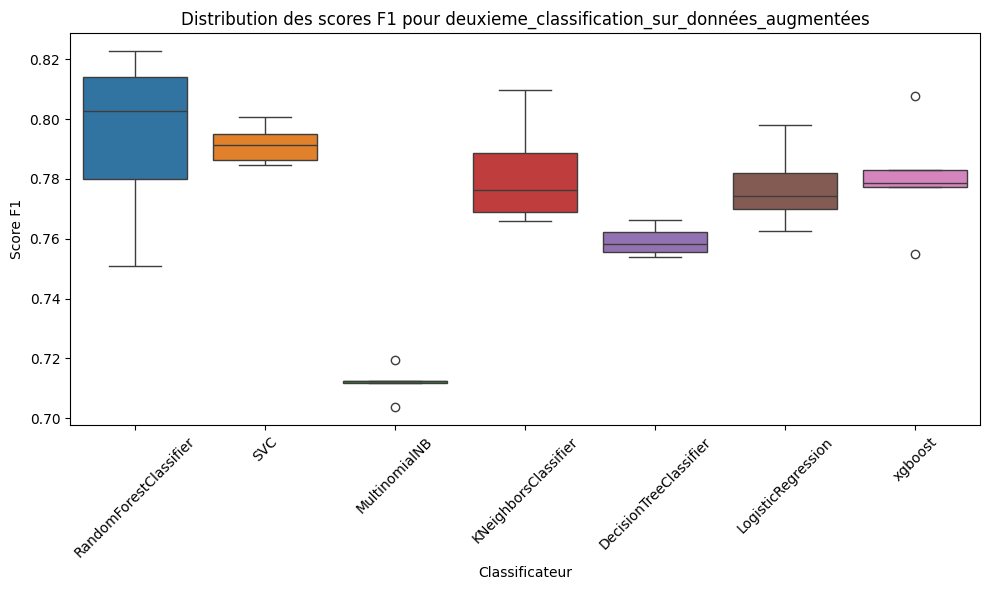


 External prediction

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04719076471686872,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=369, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

              precision    recall  f1-score   support

           0       0.69      0.57      0.62       765
           1       0.35      0.47      0.40       375

    accuracy                           0.5

In [ ]:
path = 'final.tsv'

df_1 = initialize(path)
df_1['text'] = df_1['text'].apply(full_clean)
vect_1 = tfidf_vectorizer(df_1['text'])
bst = test_optuna_binary(vect_1, df_1['science_related'])
external_predict('scitweets_export.tsv', 'science_related', bst)

1

Optimisation pour : RandomForestClassifier
Meilleurs paramètres : {'n_estimators': 164, 'max_depth': 20}
[[111  42]
 [ 10  65]]
F1 : 0.6938860147235627 
Accuracy :0.7473684210526316 
 Precision : 0.5778180964344226 
 Recall: 0.8693333333333334


Optimisation pour : SVC
Meilleurs paramètres : {'C': 0.9921497824554808, 'kernel': 'linear', 'gamma': 0.003242214312576981}
[[104  49]
 [  8  67]]
F1 : 0.6805443818441397 
Accuracy :0.736842105263158 
 Precision : 0.5677507540256775 
 Recall: 0.8506666666666667


Optimisation pour : MultinomialNB
Meilleurs paramètres : {'alpha': 0.20538092422832266}
[[140  13]
 [ 38  37]]
F1 : 0.5491970115810222 
Accuracy :0.7614035087719299 
 Precision : 0.7263527131782945 
 Recall: 0.44266666666666665


Optimisation pour : KNeighborsClassifier
Meilleurs paramètres : {'n_neighbors': 50, 'weights': 'distance'}
[[94 59]
 [12 63]]
F1 : 0.6102942288618323 
Accuracy :0.6947368421052632 
 Precision : 0.5281237020016791 
 Recall: 0.7306666666666667


Optimisation 

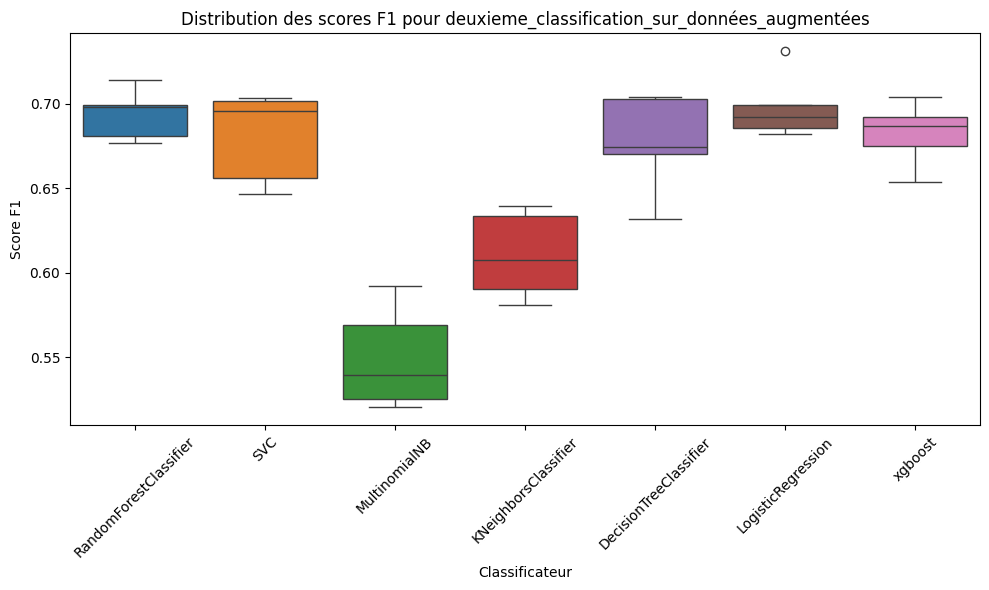


 External prediction

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.00974888686262631,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=595, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

              precision    recall  f1-score   support

           0       0.93      0.86      0.90       765
           1       0.76      0.87      0.81       375

    accuracy                           0.8

In [ ]:
path = 'scitweets_export.tsv'

df_1 = initialize(path)
df_1['text'] = df_1['text'].apply(full_clean)
vect_1 = tfidf_vectorizer(df_1['text'])
bst = test_optuna_binary(vect_1, df_1['science_related'])
external_predict('scitweets_export.tsv', 'science_related', bst)

In [ ]:
path = 'scitweets_export.tsv'

df_1 = initialize(path)
df_1['text'] = df_1['text'].apply(full_clean)
vect_1 = tfidf_vectorizer(df_1['text'])
X,y = smote( df_1['science_related'],vect_1, 'science_related')

bst = test_optuna_binary(X, y)



1


AttributeError: 'Series' object has no attribute 'toarray'

155
science_related
0    2393
1    2170
Name: count, dtype: int64

science_related
0    2170
1    2170
Name: count, dtype: int64


Optimisation pour : RandomForestClassifier
Meilleurs paramètres : {'n_estimators': 129, 'max_depth': 15}
[[271 163]
 [ 24 410]]
F1 : 0.8052628843947335 
Accuracy :0.7764976958525346 
 Precision : 0.7137054953804851 
 Recall: 0.9239631336405529


Optimisation pour : SVC
Meilleurs paramètres : {'C': 0.04090077402815068, 'kernel': 'linear', 'gamma': 0.0005110058701281586}
[[237 197]
 [ 37 397]]
F1 : 0.7721516523246703 
Accuracy :0.7324884792626728 
 Precision : 0.6725538317569325 
 Recall: 0.9064516129032258


Optimisation pour : MultinomialNB
Meilleurs paramètres : {'alpha': 0.8871161742337824}
[[362  72]
 [132 302]]
F1 : 0.7320250708977226 
Accuracy :0.7534562211981567 
 Precision : 0.8014553338444926 
 Recall: 0.6737327188940092


Optimisation pour : KNeighborsClassifier
Meilleurs paramètres : {'n_neighbors': 25, 'weights': 'distance'}
[[377  57]
 [110 324]

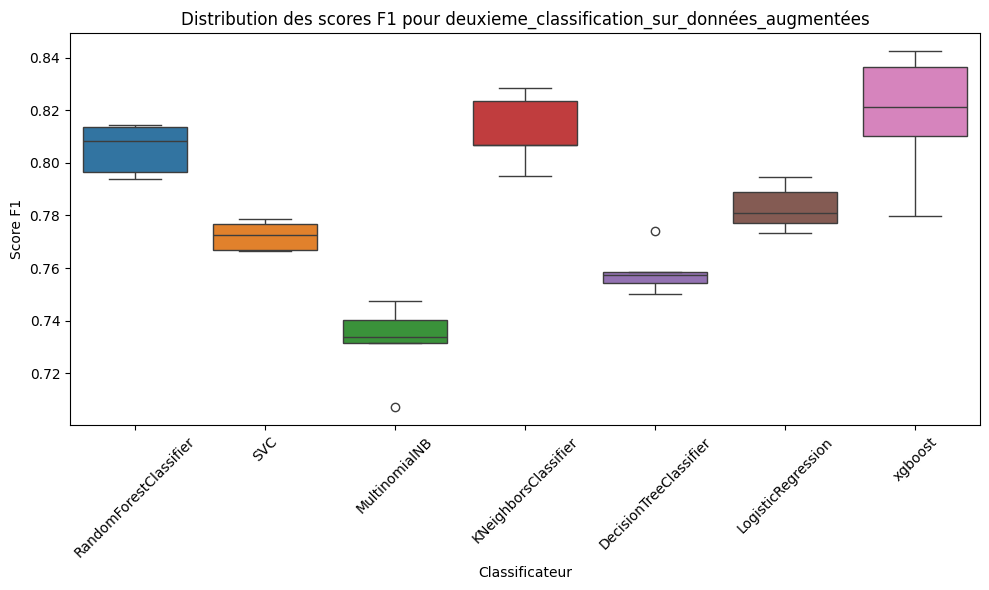


 External prediction

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01926243747302984,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=19, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=956, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

              precision    recall  f1-score   support

           0       0.66      0.29      0.41       765
           1       0.33      0.69      0.44       375

    accuracy                           0.4

In [ ]:
#Downsampling
path = 'final.tsv'

df_1 = initialize(path)
df_1['text'] = df_1['text'].apply(full_clean)
df_1 = downsampling(df_1, 'science_related')
vect_1 = tfidf_vectorizer(df_1['text'])
bst = test_optuna_binary(vect_1, df_1['science_related'])
external_predict('scitweets_export.tsv', 'science_related', bst)

In [ ]:
#Downsampling
path = 'final.tsv'

df_1 = initialize(path)
df_1['text'] = df_1['text'].apply(full_clean)
df_1 = downsampling(df_1, 'science_related')
vect_1 = word2vec_vectorizer(df_1['text'])
bst = test_optuna_binary(vect_1, df_1['science_related'])
external_predict('scitweets_export.tsv', 'science_related', bst)

In [ ]:
path = 'final.tsv'

df_1 = initialize(path)
df_1['text'] = df_1['text'].apply(full_clean)
df_1.head()
lst = lstm_bin(df_1['text'], df_1['science_related'])
external_predict('scitweets_export.tsv', 'science_related', lst)


155


NameError: name 'vocab_size' is not defined

In [ ]:
path = 'final.tsv'

df_1 = initialize(path)
df_1['text'] = df_1['text'].apply(full_clean)
df_1 = downsampling(df_1, 'science_related')
lst = lstm_bin(df_1['text'], df_1['science_related'])
external_predict('scitweets_export.tsv', 'science_related', lst)


155
science_related
0    2393
1    2170
Name: count, dtype: int64

science_related
0    2170
1    2170
Name: count, dtype: int64



NameError: name 'vocab_size' is not defined

## {CLAIM, REF} vs. {CONTEXT}

155

Optimisation pour : RandomForestClassifier
Meilleurs paramètres : {'n_estimators': 200, 'max_depth': 27}
[[523 157]
 [141 285]]
F1 : 0.6552723907281605 
Accuracy :0.7326449635804375 
 Precision : 0.650409471792917 
 Recall: 0.6604142502071251


Optimisation pour : SVC
Meilleurs paramètres : {'C': 45.5893533385458, 'kernel': 'rbf', 'gamma': 0.09171352587760948}
[[513 167]
 [133 293]]
F1 : 0.6768560243130977 
Accuracy :0.7371621654733727 
 Precision : 0.6424345577733054 
 Recall: 0.7153637116818559


Optimisation pour : MultinomialNB
Meilleurs paramètres : {'alpha': 0.044565367633284114}
[[576 104]
 [228 198]]
F1 : 0.5549213863645276 
Accuracy :0.7046266484364663 
 Precision : 0.6604706093095025 
 Recall: 0.47863131731565867


Optimisation pour : KNeighborsClassifier
Meilleurs paramètres : {'n_neighbors': 1, 'weights': 'distance'}
[[509 171]
 [163 263]]
F1 : 0.6462707670601219 
Accuracy :0.7143838894687922 
 Precision : 0.6169129026750444 
 Recall: 0.6792013256006628


Optimisation 

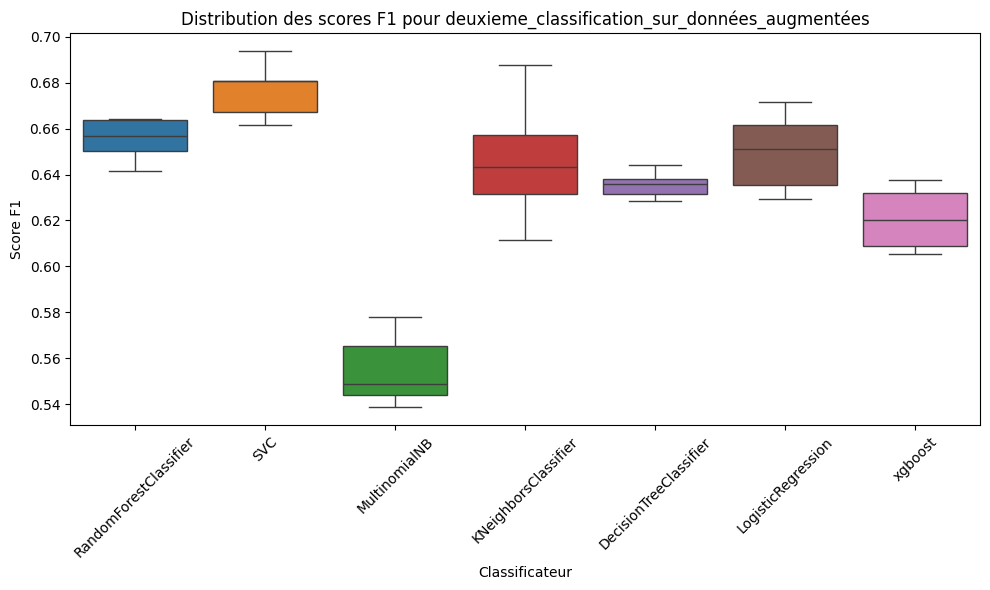


 External prediction

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09971637627746811,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=152, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

              precision    recall  f1-score   support

           0       0.65      0.63      0.64       877
           1       0.33      0.35      0.34       466

    accuracy                           0.5

In [ ]:
path = 'final.tsv'

df_2 = initialize(path)
df_2['text'] = df_2['text'].apply(full_clean)
df_2 = duplicate_row(df_2)
df_2['crc'] = df_2.apply(map_labels1, axis=1)
vect_2 = tfidf_vectorizer(df_2['text'])

bst = test_optuna_binary(vect_2, df_2['crc'])

external_predict2('scitweets_export.tsv', bst)

1

Optimisation pour : RandomForestClassifier
Meilleurs paramètres : {'n_estimators': 112, 'max_depth': 30}
[[116  59]
 [  7  86]]
F1 : 0.6689721336290987 
Accuracy :0.7237834988625645 
 Precision : 0.5729095982010469 
 Recall: 0.8069091741020361


Optimisation pour : SVC
Meilleurs paramètres : {'C': 0.4542116429512674, 'kernel': 'linear', 'gamma': 0.014989791873214144}
[[113  62]
 [  9  84]]
F1 : 0.6716799761448895 
Accuracy :0.7096238140154247 
 Precision : 0.5532570017039351 
 Recall: 0.8563486616334934


Optimisation pour : MultinomialNB
Meilleurs paramètres : {'alpha': 0.0011059301977572149}
[[152  23]
 [ 47  46]]
F1 : 0.5968518035455501 
Accuracy :0.7646951118015869 
 Precision : 0.7353444176177933 
 Recall: 0.5044840997483413


Optimisation pour : KNeighborsClassifier
Meilleurs paramètres : {'n_neighbors': 10, 'weights': 'distance'}
[[156  19]
 [ 45  48]]
F1 : 0.5811643209111563 
Accuracy :0.752055706597126 
 Precision : 0.7029306955394826 
 Recall: 0.49569892473118277


Optimis

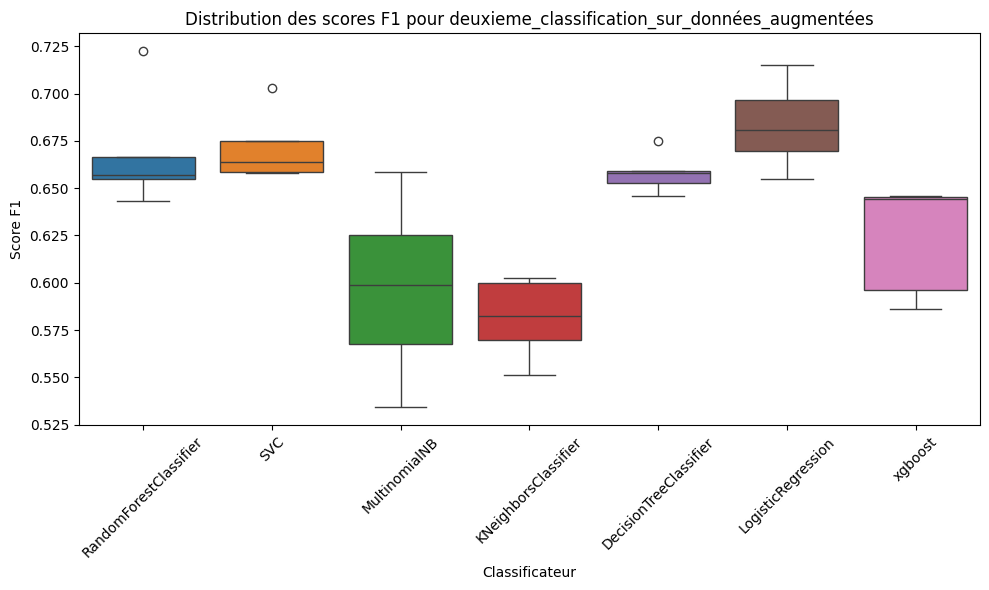

In [ ]:
path = 'scitweets_export.tsv'

df_2 = initialize(path)
df_2['text'] = df_2['text'].apply(full_clean)
df_2.head()
df_2 = duplicate_row(df_2)
df_2['crc'] = df_2.apply(map_labels1, axis=1)
vect_2 = tfidf_vectorizer(df_2['text'])

bst = test_optuna_binary(vect_2, df_2['crc'])



155
crc
0    2826
1    2706
Name: count, dtype: int64

crc
1    2706
0    2706
Name: count, dtype: int64


Optimisation pour : RandomForestClassifier
Meilleurs paramètres : {'n_estimators': 107, 'max_depth': 19}
[[455  86]
 [134 407]]
F1 : 0.7858619424725273 
Accuracy :0.7581314654473522 
 Precision : 0.7129542296805531 
 Recall: 0.887274488271685


Optimisation pour : SVC
Meilleurs paramètres : {'C': 0.6681142491418062, 'kernel': 'rbf', 'gamma': 0.043238214649252184}
[[274 267]
 [ 38 503]]
F1 : 0.7603626684753603 
Accuracy :0.7054667752170581 
 Precision : 0.6411420274255019 
 Recall: 0.9342184419995772


Optimisation pour : MultinomialNB
Meilleurs paramètres : {'alpha': 0.6250585137355914}
[[440 101]
 [160 381]]
F1 : 0.7207036284134185 
Accuracy :0.7250604622266825 
 Precision : 0.7370480527936715 
 Recall: 0.7110312323086262


Optimisation pour : KNeighborsClassifier
Meilleurs paramètres : {'n_neighbors': 3, 'weights': 'distance'}
[[335 206]
 [ 64 477]]
F1 : 0.7744460495028896 
Accu

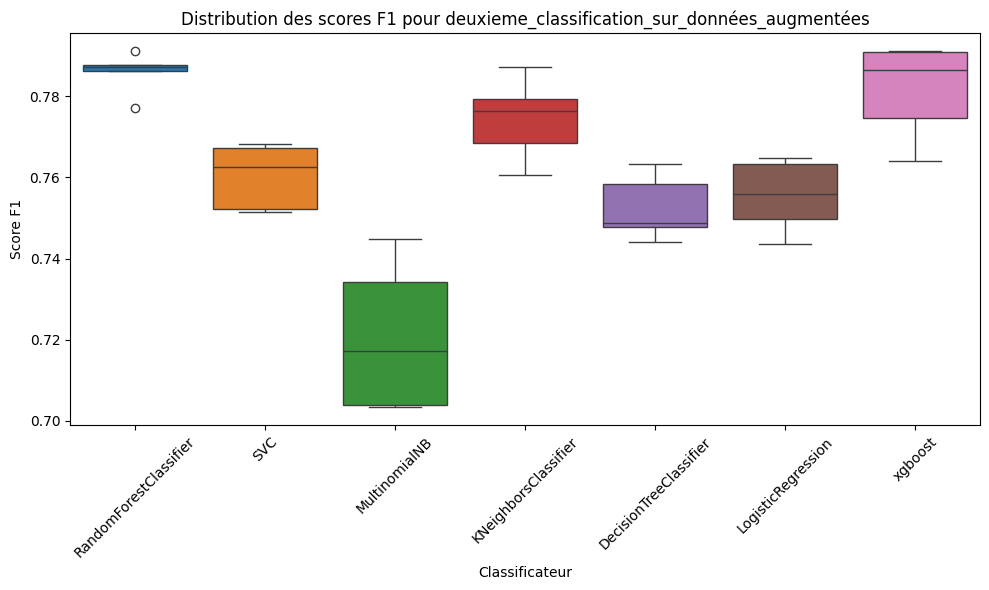

NameError: name 'lst' is not defined

In [ ]:
#downsample + duplication
path = 'final.tsv'

df_2 = initialize(path)
df_2['text'] = df_2['text'].apply(full_clean)

df_2['crc'] = df_2.apply(map_labels1, axis=1)

df_2 = duplicate_row(df_2)

df_2 = downsampling(df_2, 'crc')
vect_2 = tfidf_vectorizer(df_2['text'])

bst = test_optuna_binary(vect_2, df_2['crc'])
external_predict2('scitweets_export.tsv', bst)


In [ ]:
path = 'scitweets_export.tsv'

df_2 = initialize(path)
df_2['text'] = df_2['text'].apply(full_clean)
df_2.head()
df_2 = duplicate_row(df_2)
df_2['crc'] = df_2.apply(map_labels1, axis=1)
vect_2 = tfidf_vectorizer(df_2['text'])
X,y = smote(df_2, vect_2, 'crc')
bst = test_optuna_binary(X,y)
external_predict2('scitweets_export.tsv', bst)


In [ ]:
path = 'final.tsv'

df_2 = initialize(path)
df1, df2 = embedded_preprocess(df_2)
embedded_classification(df1, df2)

In [ ]:
path = 'final.tsv'

df_2 = initialize(path)
df1, df2 = embedded_preprocess(df_2)
embedded_classification(df1, df2)
external_predict2('scitweets_export.tsv',)

In [ ]:
path = 'scitweets_export.tsv'

df_2 = initialize(path)
df1, df2 = embedded_preprocess(df_2)
embedded_classification(df1, df2)

In [ ]:
path = 'scitweets_export.tsv'

df_2 = initialize(path)
df_2['text'] = df_2['text'].apply(full_clean)
df_2 = duplicate_row(df_2)

df_2['crc'] = df_2.apply(map_labels1, axis=1)
lst = lstm_bin(df_2['text'], df_2['crc'])


## {CLAIM} VS {REF} VS {CONTEXT}

###Classification multi-classe MultiOuput avec labellisation Powerset

In [ ]:
df = initialize('final.tsv')
df = powerset(df)
df.drop(df[df['science_related'] == 0].index, inplace=True)
df['text'] = df['text'].apply(full_clean)
df.reset_index()
le, df = label_encoding(df)
vect = tfidf_vectorizer(df['text'])

X = vect
y = df['powerset_label_encoded']
y = np.array(y)
best_model = test_multi_powerset(X, y)

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.2, random_state=42)

best_model.fit(X_train_final, y_train_final)
y_pred_final = best_model.predict(X_test_final)

print(best_model)
print(hamming_loss(y_test_final, y_pred_final))

print(classification_report(y_test_final, y_pred_final, target_names=le.classes_, zero_division=0))


In [ ]:
df = initialize('scitweets_export.tsv')
df = powerset(df)
df.drop(df[df['science_related'] == 0].index, inplace=True)
df['text'] = df['text'].apply(full_clean)
df.reset_index()
le, df = label_encoding(df)
vect = tfidf_vectorizer(df['text'])

X = vect
y = df['powerset_label_encoded']
y = np.array(y)
best_model = test_multi_powerset(X, y)

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.2, random_state=42)

best_model.fit(X_train_final, y_train_final)
y_pred_final = best_model.predict(X_test_final)

print(best_model)
print(hamming_loss(y_test_final, y_pred_final))

print(classification_report(y_test_final, y_pred_final, target_names=le.classes_, zero_division=0))


###Classification chaînée

In [ ]:
df = initialize('final.tsv')

y = df[['scientific_claim', 'scientific_reference', 'scientific_context']].astype(int)
df['text'] = df['text'].apply(full_clean)
X = tfidf_vectorizer(df['text'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_clf = xgboost.XGBClassifier()
#base_clf = RandomForrestclassifier(class_weight='balanced', random_state=42)
chain_model = ClassifierChain(base_clf, order='random', random_state=42)

chain_model.fit(X_train, y_train)

y_pred = chain_model.predict(X_test)

labels = y.columns
mcm = multilabel_confusion_matrix(y_test, y_pred)

for i, label in enumerate(labels):
    print(f"\n Matrice de confusion pour le label : {label}")
    print(mcm[i])

print("Hamming Loss :", hamming_loss(y_test, y_pred))
print("\nClassification report (multi-label, par label) :")
print(classification_report(y_test, y_pred, target_names=y.columns, zero_division=0))

### Classification avec LSTM adaptée pour du multi-classe

In [ ]:
df = initialize('final.tsv')
texts = df['text'].apply(full_clean)
labels = df[['science_related', 'scientific_claim', 'scientific_reference']].astype(int)

best_lstm_model = lstm_multi(texts, labels)

### Stratégie One VS the Rest

In [ ]:
path = "scitweets_export.tsv"
df_base = initialize(path)
df_base["text"] = df_base["text"].apply(full_clean)
df_base['label2'] = df_base.apply(map_labels2, axis=1)
y_val = np.array(df_base['label2'][df_base['science_related'] == 1])
y_val = [np.array(e) for e in y_val]

Classification en utilisant les chaînes de classifieur binaires OneVsTheRest

In [ ]:
path = "final.tsv"
df_3= initialize(path)
df_3["text"] = df_3["text"].apply(full_clean)
vect_3 = tfidf_vectorizer(df_3["text"])
df_3['label2'] = df_3.apply(map_labels2, axis=1)
y = np.array(df_3['label2'])
y = [np.array(e) for e in y]
X_val = tfidf_vectorizer(df_base["text"][df_base['science_related'] == 1])
bst = test_optuna_multilabel(vect_3, np.array(y),X_val,np.array(y_val))

Même stratégie mais avec des prétraitements différents

In [ ]:
newX = tfidf_vectorizer2(df_3["text"])
X_val = tfidf_vectorizer2(df_base["text"][df_base['science_related'] == 1])
bst = test_optuna_multilabel(newX, np.array(y),X_val,np.array(y_val))

### Powerset One Vs One

In [ ]:
path = "scitweets_export.tsv"
df_base = initialize(path)
df_base["text"] = df_base["text"].apply(full_clean)
df_base['label2'] = df_base.apply(map_labels2, axis=1)
y_val = np.array(df_base['label2'][df_base['science_related'] == 1])
y_val = [np.array(e) for e in y_val]

In [ ]:
X = tfidf_vectorizer(df_base["text"][df_base['science_related'] == 1])

X_train,X_test,y_train,y_test = train_test_split(X,np.array(y_val),train_size=0.8,test_size=0.2,random_state=7)

powerset = LabelPowerset()
new_y = powerset.transform(y_train)
new_y_test = powerset.transform(y_test)
clf = OneVsOneClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_train, new_y)
y_pred = clf.predict(X_test)
print(type(y_pred))
print(y_pred.shape)

In [ ]:
confusion_matrix(new_y_test,y_pred)

In [ ]:
path = "final.tsv"
df_3= initialize(path)
df_3["text"] = df_3["text"].apply(full_clean)
vect_3 = tfidf_vectorizer(df_3["text"][df_3["science_related"] == 1])
df_3['label2'] = df_3.apply(map_labels2, axis=1)
y = np.array(df_3['label2'][df_3["science_related"] == 1])
y = [np.array(e) for e in y]
X_val = tfidf_vectorizer(df_base["text"][df_base['science_related'] == 1])
bst = test_optuna_powerset(vect_3, np.array(y),X_val,np.array(y_val))